In [1]:
# Imports
import os

# import methods from FIA python script
from FIA import *

oms.LogConfigHandler().setLogLevel("DEBUG")

## Loading

In [2]:
# set path to your mzML files and workfolder
data_dir = "../../data/example data/exampleA_ecolistrains"
run_dir = "../../runs/fia_explorer"

data_dir = os.path.normpath(os.path.join(os.getcwd(), data_dir))
run_dir = os.path.normpath(os.path.join(os.getcwd(), run_dir))

# clean_dir(run_dir)

In [3]:
fia_df = load_fia_df(data_dir, ".mzXML")

Loading experiments:


100%|██████████| 6/6 [00:04<00:00,  1.49it/s]


Loading names:


100%|██████████| 6/6 [00:00<00:00, 5931.14it/s]


## Initial Centroiding

In [4]:
"""
fia_df["cent_experiment"] = fia_df["experiment"].apply(lambda experiment: centroid_experiment(experiment, instrument="Orbitrap",                                      # For All
                                                                                                signal_to_noise=1.0, spacing_difference=1.5,                        
                                                                                                spacing_difference_gap=4.0, missing=1, ms_levels=[1],                   # For Orbitrap
                                                                                                report_FWHM="true", report_FWHM_unit="relative", max_intensity=-1,
                                                                                                auto_max_stdev_factor=3.0, auto_max_percentile=95, auto_mode=0,
                                                                                                win_len=200.0, bin_count=30, min_required_elements=10, 
                                                                                                noise_for_empty_window=1e+20, write_log_messages="true",            
                                                                                                peak_width=0.0, sn_bin_count=30, nr_iterations=5, sn_win_len=20.0,      # For TOF
                                                                                                check_width_internally="false", ms1_only="true", clear_meta_data="false",
                                                                                                deepcopy=False))
"""
# centroid_dir = os.path.join(run_dir, "centroids")

'\nfia_df["cent_experiment"] = fia_df["experiment"].apply(lambda experiment: centroid_experiment(experiment, instrument="Orbitrap",                                      # For All\n                                                                                                signal_to_noise=1.0, spacing_difference=1.5,                        \n                                                                                                spacing_difference_gap=4.0, missing=1, ms_levels=[1],                   # For Orbitrap\n                                                                                                report_FWHM="true", report_FWHM_unit="relative", max_intensity=-1,\n                                                                                                auto_max_stdev_factor=3.0, auto_max_percentile=95, auto_mode=0,\n                                                                                                win_len=200.0, bin_count=30, min_required_element

## Data pruning & binning

In [5]:
# Computes mean, media or sum of binned peaks (median needs ~2* more time)
fia_df["sum_experiment"] = fia_df["experiment"].apply(lambda experiment: limit_experiment(experiment, 51, 1699, 2*10**6, statistic="sum", deepcopy=True))

## Combining 

In [6]:
# merge_dir = merge_batch(centroid_dir, run_dir, block_size=None, mz_binning_width=5.0, mz_binning_width_unit="ppm", average_gaussian_cutoff=0.01, file_ending=".mzML")
# merge_dir = os.path.join(run_dir, "merged")

In [7]:
fia_df["comb_spectrum"] = fia_df["sum_experiment"].apply(lambda experiment: combine_spectra(experiment)) # type: ignore

In [20]:
s = fia_df["comb_spectrum"][0]
pd.DataFrame(np.array(s.get_peaks()).transpose(), columns=["mz", "intensity"])

,mz,intensity
0,51.000412,3082.0
1,51.001236,3840.0
2,51.002060,4243.0
3,51.002884,3719.0
4,51.003708,4018.0
...,...,...
1999995,1698.996292,882.0
1999996,1698.997116,4873.0
1999997,1698.997940,1555.0
1999998,1698.998764,1955.0


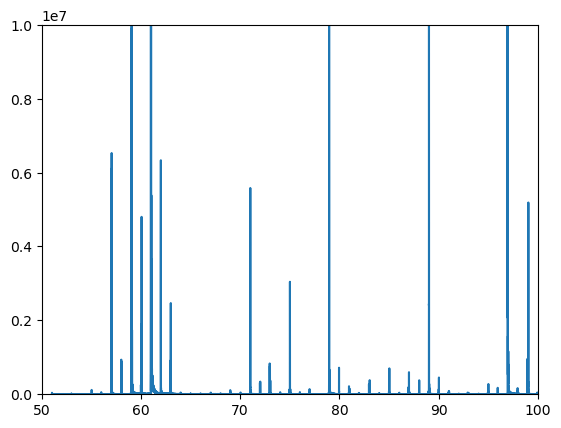

In [13]:
quick_plot(fia_df["comb_spectrum"][0], xlim=[50,100], ylim=[-1, 10000000], plottype="line")

## Clustering

In [38]:
np.stack(fia_df["comb_spectrum"][0].get_peaks(), axis=-1)

array([[  51.000412, 3082.      ],
       [  51.001236, 3840.      ],
       [  51.00206 , 4243.      ],
       ...,
       [1698.99794 , 1555.      ],
       [1698.998764, 1955.      ],
       [1698.999588, 2783.      ]])

In [21]:
from sklearn.cluster import *

In [39]:
sc = SpectralClustering(n_clusters=1000, eigen_solver="amg", n_components=None, random_state=None, n_init=10, gamma=1.0,
                        affinity='rbf', n_neighbors=10, eigen_tol='auto', assign_labels='cluster_qr', degree=3, coef0=1, 
                        kernel_params=None, n_jobs=None, verbose=False)
cluster = sc.fit(np.stack(fia_df["comb_spectrum"][0].get_peaks(), axis=-1))

MemoryError: Unable to allocate 29.1 TiB for an array with shape (2000000, 2000000) and data type float64

In [27]:
cluster.labels_

1

In [9]:
## Itertools
from itertools import combinations

In [ ]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import single, fcluster, complete, complete, dendrogram

In [ ]:
a = [1,2,3]
b = [1,2,6]
c = [10,11,12]
d = [10, 20, 30]
pdist([ [1, 10],  [11, 100], [2, 10], [2, 11]], metric="correlation")

array([0., 0., 0., 0., 0., 0.])

In [ ]:
mzs, intensities = fia_df["comb_spectrum"][0].get_peaks()
mzs

array([  51.000412,   51.001236,   51.00206 , ..., 1698.99794 ,
       1698.998764, 1698.999588])

In [ ]:
distances = pdist(mzs, metric="euclidean") * pdist(intensities, metric="correlation")

ValueError: A 2-dimensional array must be passed.

In [ ]:
cluster = complete(distances)

{'icoord': [[25.0, 25.0, 35.0, 35.0],
  [15.0, 15.0, 30.0, 30.0],
  [5.0, 5.0, 22.5, 22.5]],
 'dcoord': [[0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0],
  [0.0, 0.6026402928804868, 0.6026402928804868, 0.0]],
 'ivl': ['1', '3', '0', '2'],
 'leaves': [1, 3, 0, 2],
 'color_list': ['C1', 'C1', 'C0'],
 'leaves_color_list': ['C0', 'C1', 'C1', 'C1']}

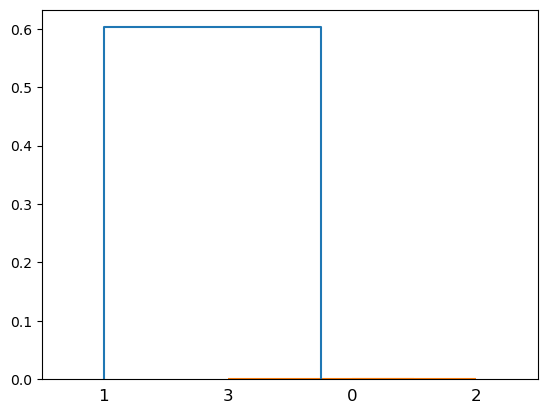

In [ ]:
dendrogram(cluster)

In [ ]:
fcluster(cluster, 0.5, criterion="distance")

array([1, 2, 1, 1], dtype=int32)

#### Summing intensities

In [ ]:
exp = fia_df.loc[0, "lim_experiment"]
exp.getSpectra()[0].get_peaks()[1][-50:]

array([ 61.,   0.,   0.,   0.,  58.,   0.,   0.,   3.,   0.,   0.,   0.,
         3.,   0.,   0.,   0.,   3.,   0.,   0.,   0.,   3.,   0.,   0.,
         0.,   3.,   0.,   0.,   0.,  49.,   0.,   0.,   0.,  52.,   0.,
         0.,   0.,  42.,   0.,   0.,   0., 263.,   0.,   0.,   0., 269.,
         0.,   0., 238.,   0.,   0.,   0.], dtype=float32)

In [ ]:
bins = np.linspace(1, 10, 100)
np.digitize(np.array([1,1.6,2,2,3,8,8,8,8,8,8]), bins)

array([ 1,  7, 12, 12, 23, 78, 78, 78, 78, 78, 78], dtype=int64)

In [ ]:
fia_df

,sample,polarity,experiment,lim_experiment
0,mg1655,-1,<pyopenms._dataframes._MSExperimentDF object a...,<pyopenms._pyopenms_5.MSExperiment object at 0...
1,mg1655,1,<pyopenms._dataframes._MSExperimentDF object a...,<pyopenms._pyopenms_5.MSExperiment object at 0...
2,nissle,-1,<pyopenms._dataframes._MSExperimentDF object a...,<pyopenms._pyopenms_5.MSExperiment object at 0...
3,nissle,1,<pyopenms._dataframes._MSExperimentDF object a...,<pyopenms._pyopenms_5.MSExperiment object at 0...
4,tue1,-1,<pyopenms._dataframes._MSExperimentDF object a...,<pyopenms._pyopenms_5.MSExperiment object at 0...
5,tue1,1,<pyopenms._dataframes._MSExperimentDF object a...,<pyopenms._pyopenms_5.MSExperiment object at 0...
